In [1]:
# importing useful libraries

import requests
import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import osxphotos
import pyforest
import os
np.random.seed(42)

In [2]:

!osxphotos export  --not-shared --not-hidden --from-date "2020-01-01T12:00:00" --jpeg-ext jpg --only-photos ./bibliotek --convert-to-jpeg --directory "{created.year}"

Using last opened Photos library: /Users/darylfelix/Pictures/Photothèque.photoslibrary
Exporting 4112 photos to /Users/darylfelix/Development/ml/photos-analyser/bibliotek...
  [####################################]  100%          
Processed: 4112 photos, exported: 3900, missing: 1606, error: 0
Elapsed time: 748.089 seconds


In [3]:
def download(url, file_name):
    """
    Downloads the dataset for project
    input:
    url (string): url for dataset
    file_name (string): file name in which downloaded dataset will be stored
    """
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(file_name, 'wb') as f:
            f.write(response.raw.read())

In [4]:
def extract_zip(s_path, d_path):
    """
    Extract (unzip) the compressed dataset for working
    input:
    s_path (string): path of zipped dataset
    d_path (string): path to store the unzipped dataset
    """
    with zipfile.ZipFile(s_path, 'r') as zip_ref:
        zip_ref.extractall(d_path)

In [5]:
def center_crop(image_path, size):
    """
    crop the image from center of the given size
    input:
    image_path (string): Path of image
    size (int): size to which the image being cropped from center
    """
    try:
        img = Image.open(image_path)
        img = img.resize((size+1,size+1))
        x_center = img.width/2
        y_center = img.height/2
        size = size/2
        cr = img.crop((x_center-size, y_center-size, x_center+size, y_center+size))
    except:
        print('Unable to open', image_path)
        cr=None
    return cr


In [6]:
photos_by_year={}
for y in range(2020,2023):
    try:
        photos_by_year[str(y)]= os.listdir(f"bibliotek/{y}")
    except:
        continue
        

In [7]:
one_photo = photos_by_year['2021'][11]
prefix = 'bibliotek/2021'
one_photo

'IMG_6303.jpg'

In [8]:
import PIL
import PIL.Image as PILI
#from PIL import Image

print(PIL.__version__)

8.4.0


In [9]:
img_path = f'{prefix}/{one_photo}'
with Image.open(img_path) as img:
    print(img)


img = PILI.open(img_path).convert('RGB')

print(img)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4032x3024 at 0x7FBCE9C46160>
<PIL.Image.Image image mode=RGB size=4032x3024 at 0x7FBCE9C46FA0>


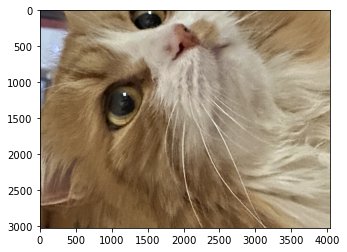

In [10]:
plt.imshow(img)

In [11]:
all_photos = []
# create dataset with all photos
for key in photos_by_year:
    list_of_year = photos_by_year[key]
    
    for i in list_of_year:
        if 'mov' not in i and 'edited' not in i and '(1)' not in i:
            all_photos.append(f"bibliotek/{key}/{i}")
        
len(all_photos)
train_list=all_photos
train_list[:5]

['bibliotek/2020/_DSC0606.jpg',
 'bibliotek/2020/_DSC0612.jpg',
 'bibliotek/2020/IMG_5839.jpg',
 'bibliotek/2020/_DSC0821.jpg',
 'bibliotek/2020/IMG_4266.jpg']

In [12]:
np.random.shuffle(train_list)
try:
    train_list.remove('.ipynb_checkpoints')
    train_list.remove('.ipynb_checkpoints')
except:
    pass
train_list[:4]

['bibliotek/2020/IMG_5601.jpg',
 'bibliotek/2020/_DSC0547.jpg',
 'bibliotek/2021/_DSC0006.jpg',
 'bibliotek/2020/_DSC0632.jpg']

In [13]:
l=len(train_list)
l

2451

In [14]:
train_data = np.zeros((l,100*100*3))

In [15]:
i=0
for key in train_list:
    image_name =key
    image_path = f"{image_name}"
    try:
        crp_img = center_crop(image_path,100)
        crp_arr = np.array(crp_img).reshape(-1)
        train_data[i] = crp_arr
    except ValueError:
        print(f"unable to open {image_name} - {ValueError}")
        continue
    i=i+1

In [16]:
train_data[0]

array([144., 135., 126., ...,  78.,  74.,  62.])

In [41]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=25, random_state=0).fit(train_data[:3000])

In [42]:
predict=kmeans.predict(train_data)
predict

array([ 9, 15, 15, ...,  4,  9, 23], dtype=int32)

In [43]:
pd.DataFrame(predict).value_counts()

<IPython.core.display.Javascript object>

15    233
23    211
4     206
14    158
0     131
8     126
7     106
21    102
3      96
9      90
12     89
2      85
13     84
16     81
1      80
10     78
20     72
24     72
5      69
11     64
17     62
18     59
19     51
6      34
22     12
dtype: int64

In [45]:
for c in range(1,31):
    new_folder = f"cluster/{c}"
    os.mkdir(new_folder)


In [46]:
from shutil import copyfile
idx=0
for file in train_list:


    filename = file.split('/')[2]
    dest_file = f'cluster/{predict[idx]+1}/{filename}'
    
    copyfile(file, dest_file)
    idx+=1